<a href="https://colab.research.google.com/github/olhaishchenko/-data_science/blob/master/HW_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import os
import random
from PIL import Image

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import CategoricalAccuracy
import albumentations as A


In [ ]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

In [ ]:
num_classes = 10
num_features = 28*28
new_size = (32, 32)

lr = 0.001
n_epochs = 10
batch_size = 256

In [ ]:

label = \
{
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot",
}


# **Частина 2**
В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
# Загружаем датасет
(x_train, y_train), (x_test_vgg16, y_test_vgg16) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
x_train_part_vgg16, x_valid_vgg16, y_train_part_vgg16, y_valid_vgg16 = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

Trouser (28, 28)


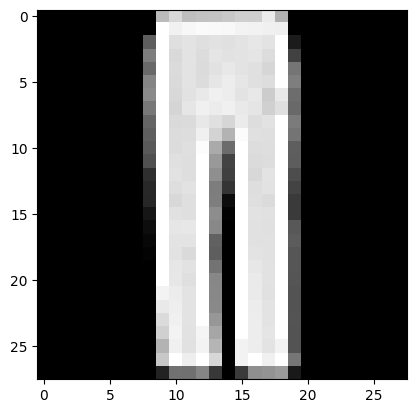

In [ ]:
idx_sample = 105
plt.imshow(x_train_part_vgg16[idx_sample], cmap="gray")
x_train_part_vgg16
print(label[y_train_part_vgg16[idx_sample]], x_train_part_vgg16[idx_sample].shape)

In [ ]:
from PIL import Image

class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256, transforms=None):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size
        self.transforms = transforms

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, n):
        indexes = self.indexes[n * self.batch_size : (n + 1) * self.batch_size]
        batch_y = tf.keras.utils.to_categorical(self.y[indexes], num_classes)
        batch_X = []
        for i in range(self.batch_size):
          #  конвертує вхідні зображення у форматі NumPy у формат RGB
          for i in indexes:
            img = np.asarray(Image.fromarray(np.uint8(self.x[i])).convert('RGB'))

            if self.transforms:
                img = self.transforms(image=img)["image"]

            batch_X.append(img)

        return np.array(batch_X)/255., batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
train_transforms = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.Rotate(limit=45, p=0.5),
        # A.Blur(p=0.25),
        A.Resize(32, 32, p=1.),
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(32, 32, p=1.),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(32, 32, p=1.),
    ]
)

In [ ]:
train_dataset_vgg = Dataset(x_train_part_vgg16, y_train_part_vgg16, shuffle=True, batch_size=256, transforms=train_transforms)
valid_dataset_vgg = Dataset(x_valid_vgg16, y_valid_vgg16, shuffle=False, batch_size=16, transforms=valid_transforms)
test_dataset_vgg = Dataset(x_test_vgg16, y_test_vgg16, shuffle=False, batch_size=16, transforms=test_transforms)


In [ ]:
X, y = train_dataset_vgg[0]
X.shape, y.shape

((65536, 32, 32, 3), (256, 10))

In [ ]:
from tensorflow.keras.applications import vgg16

base_model = vgg16.VGG16(input_shape=(32, 32, 3), include_top=False)
base_model.trainable = False

model_vgg16 = Sequential(
    [
        base_model,
        # GlobalAveragePooling2D(),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_vgg16.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=[CategoricalAccuracy()],
)

In [ ]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model_vgg16.fit(
    train_dataset_vgg,
    validation_data=valid_dataset_vgg,
    epochs=1,
    verbose=1,
    callbacks=[callback_early_stopping, callback_save]
)

ResourceExhaustedError: ignored